<a href="https://colab.research.google.com/github/manishmcsa/S10/blob/main/S10_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/S10"

/content/drive/MyDrive/S10


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data_engine import DataEngine
from config import ModelConfig
from resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from visualize import VisualizeCam
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Files already downloaded and verified
Files already downloaded and verified
 deer   car horse   dog


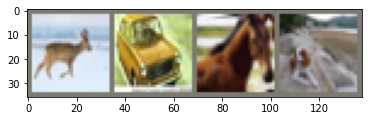

In [5]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [6]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


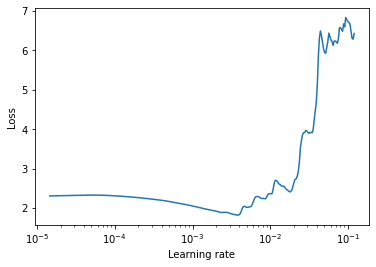

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2,
                     num_iter=len(data.train_loader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.8203645633914016
Best Learning Rate: 0.003886025993068028


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.2449951171875 L1_loss=109137.2109375 Loss=1.9176971912384033 Batch_id=390 Accuracy=49.91: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 6167/10000 (61.67%)

EPOCH: 2


L2_loss=459.4648742675781 L1_loss=108838.578125 Loss=1.6550441980361938 Batch_id=390 Accuracy=68.53: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 7281/10000 (72.81%)

EPOCH: 3


L2_loss=459.5260009765625 L1_loss=108524.921875 Loss=1.528681755065918 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7531/10000 (75.31%)

EPOCH: 4


L2_loss=459.5183410644531 L1_loss=108221.7578125 Loss=1.2846124172210693 Batch_id=390 Accuracy=79.75: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 8025/10000 (80.25%)

EPOCH: 5


L2_loss=459.48272705078125 L1_loss=107922.3046875 Loss=1.4449830055236816 Batch_id=390 Accuracy=82.50: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7673/10000 (76.73%)

EPOCH: 6


L2_loss=459.41900634765625 L1_loss=107635.4609375 Loss=1.2615022659301758 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8148/10000 (81.48%)

EPOCH: 7


L2_loss=459.34210205078125 L1_loss=107356.1328125 Loss=1.212235689163208 Batch_id=390 Accuracy=86.37: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 7925/10000 (79.25%)

EPOCH: 8


L2_loss=459.26898193359375 L1_loss=107085.96875 Loss=1.0766600370407104 Batch_id=390 Accuracy=87.93: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8335/10000 (83.35%)

EPOCH: 9


L2_loss=459.1692810058594 L1_loss=106816.625 Loss=0.9700314998626709 Batch_id=390 Accuracy=89.25: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8416/10000 (84.16%)

EPOCH: 10


L2_loss=459.06610107421875 L1_loss=106568.34375 Loss=1.0623738765716553 Batch_id=390 Accuracy=90.23: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8317/10000 (83.17%)

EPOCH: 11


L2_loss=458.9311828613281 L1_loss=106315.984375 Loss=0.9314770698547363 Batch_id=390 Accuracy=91.27: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 8040/10000 (80.40%)

EPOCH: 12


L2_loss=458.7624816894531 L1_loss=106059.8828125 Loss=1.1687027215957642 Batch_id=390 Accuracy=92.01: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0040, Accuracy: 8437/10000 (84.37%)

EPOCH: 13


L2_loss=458.599609375 L1_loss=105809.9375 Loss=1.0758991241455078 Batch_id=390 Accuracy=92.74: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8504/10000 (85.04%)

EPOCH: 14


L2_loss=458.39593505859375 L1_loss=105553.9609375 Loss=1.0259250402450562 Batch_id=390 Accuracy=93.25: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8402/10000 (84.02%)

EPOCH: 15


L2_loss=458.1725158691406 L1_loss=105301.359375 Loss=0.9560836553573608 Batch_id=390 Accuracy=93.91: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8424/10000 (84.24%)

EPOCH: 16


L2_loss=457.9342041015625 L1_loss=105043.6171875 Loss=1.0110821723937988 Batch_id=390 Accuracy=94.30: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8441/10000 (84.41%)

EPOCH: 17


L2_loss=457.6272888183594 L1_loss=104763.4375 Loss=1.0331189632415771 Batch_id=390 Accuracy=94.88: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8590/10000 (85.90%)

Epoch    17: reducing learning rate of group 0 to 3.8860e-04.
EPOCH: 18


L2_loss=457.5124816894531 L1_loss=104700.296875 Loss=0.8033626079559326 Batch_id=390 Accuracy=97.09: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8854/10000 (88.54%)

EPOCH: 19


L2_loss=457.40289306640625 L1_loss=104636.890625 Loss=0.7874250411987305 Batch_id=390 Accuracy=97.96: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8895/10000 (88.95%)

EPOCH: 20


L2_loss=457.29510498046875 L1_loss=104573.5078125 Loss=0.8513177037239075 Batch_id=390 Accuracy=98.13: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8893/10000 (88.93%)

EPOCH: 21


L2_loss=457.1929016113281 L1_loss=104510.3046875 Loss=0.8384126424789429 Batch_id=390 Accuracy=98.26: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8903/10000 (89.03%)

EPOCH: 22


L2_loss=457.09332275390625 L1_loss=104447.1171875 Loss=0.8089540004730225 Batch_id=390 Accuracy=98.41: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8904/10000 (89.04%)

EPOCH: 23


L2_loss=456.9956359863281 L1_loss=104384.0859375 Loss=0.7779307961463928 Batch_id=390 Accuracy=98.49: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8903/10000 (89.03%)

EPOCH: 24


L2_loss=456.89910888671875 L1_loss=104321.0078125 Loss=0.820763111114502 Batch_id=390 Accuracy=98.55: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8903/10000 (89.03%)

Epoch    24: reducing learning rate of group 0 to 3.8860e-05.
EPOCH: 25


L2_loss=456.8868408203125 L1_loss=104314.359375 Loss=0.8435245752334595 Batch_id=390 Accuracy=98.73: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8903/10000 (89.03%)

EPOCH: 26


L2_loss=456.87554931640625 L1_loss=104307.859375 Loss=0.7870090007781982 Batch_id=390 Accuracy=98.84: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8913/10000 (89.13%)

EPOCH: 27


L2_loss=456.8652648925781 L1_loss=104301.3671875 Loss=0.8145183324813843 Batch_id=390 Accuracy=98.77: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8913/10000 (89.13%)

EPOCH: 28


L2_loss=456.855224609375 L1_loss=104294.8671875 Loss=0.815223217010498 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8913/10000 (89.13%)

Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 29


L2_loss=456.8523864746094 L1_loss=104293.1953125 Loss=0.7959980964660645 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8920/10000 (89.20%)

EPOCH: 30


L2_loss=456.84991455078125 L1_loss=104291.5078125 Loss=0.7796239852905273 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [01:05<00:00,  6.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8916/10000 (89.16%)

EPOCH: 31


L2_loss=456.847412109375 L1_loss=104289.84375 Loss=0.8119214773178101 Batch_id=390 Accuracy=98.77: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8916/10000 (89.16%)

EPOCH: 32


L2_loss=456.844970703125 L1_loss=104288.1796875 Loss=0.7984784245491028 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8914/10000 (89.14%)

EPOCH: 33


L2_loss=456.84246826171875 L1_loss=104286.515625 Loss=0.8107473850250244 Batch_id=390 Accuracy=98.71: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8912/10000 (89.12%)

EPOCH: 34


L2_loss=456.8399658203125 L1_loss=104284.8359375 Loss=0.8165111541748047 Batch_id=390 Accuracy=98.81: 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8916/10000 (89.16%)

EPOCH: 35


L2_loss=456.8375244140625 L1_loss=104283.1796875 Loss=0.7820698618888855 Batch_id=390 Accuracy=98.79: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8922/10000 (89.22%)

EPOCH: 36


L2_loss=456.83514404296875 L1_loss=104281.5 Loss=0.8108021020889282 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8914/10000 (89.14%)

EPOCH: 37


L2_loss=456.8327331542969 L1_loss=104279.8359375 Loss=0.8173671364784241 Batch_id=390 Accuracy=98.88: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8918/10000 (89.18%)

EPOCH: 38


L2_loss=456.8302307128906 L1_loss=104278.15625 Loss=0.7920035123825073 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8909/10000 (89.09%)

EPOCH: 39


L2_loss=456.8277282714844 L1_loss=104276.484375 Loss=0.7850080132484436 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8909/10000 (89.09%)

EPOCH: 40


L2_loss=456.8252868652344 L1_loss=104274.8203125 Loss=0.788185715675354 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8917/10000 (89.17%)

EPOCH: 41


L2_loss=456.8228454589844 L1_loss=104273.15625 Loss=0.785200834274292 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8920/10000 (89.20%)

EPOCH: 42


L2_loss=456.82037353515625 L1_loss=104271.484375 Loss=0.8434786796569824 Batch_id=390 Accuracy=98.93: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8921/10000 (89.21%)

EPOCH: 43


L2_loss=456.8179016113281 L1_loss=104269.828125 Loss=0.7836818695068359 Batch_id=390 Accuracy=98.84: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8916/10000 (89.16%)

EPOCH: 44


L2_loss=456.8154602050781 L1_loss=104268.15625 Loss=0.8753564953804016 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8917/10000 (89.17%)

EPOCH: 45


L2_loss=456.81304931640625 L1_loss=104266.5 Loss=0.8337142467498779 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8914/10000 (89.14%)

EPOCH: 46


L2_loss=456.81048583984375 L1_loss=104264.8203125 Loss=0.793858528137207 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8917/10000 (89.17%)

EPOCH: 47


L2_loss=456.80810546875 L1_loss=104263.1484375 Loss=0.802013099193573 Batch_id=390 Accuracy=98.85: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8915/10000 (89.15%)

EPOCH: 48


L2_loss=456.8056335449219 L1_loss=104261.484375 Loss=0.8268147706985474 Batch_id=390 Accuracy=98.88: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8914/10000 (89.14%)

EPOCH: 49


L2_loss=456.8031921386719 L1_loss=104259.8125 Loss=0.8095914721488953 Batch_id=390 Accuracy=98.91: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8915/10000 (89.15%)

EPOCH: 50


L2_loss=456.8006896972656 L1_loss=104258.1484375 Loss=0.8242124319076538 Batch_id=390 Accuracy=98.86: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
/content/drive/My Drive/S10/test.py:25: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  misclassified_inds = (is_correct==0).nonzero()[:,0]


Test set: Average loss: 0.0030, Accuracy: 8911/10000 (89.11%)



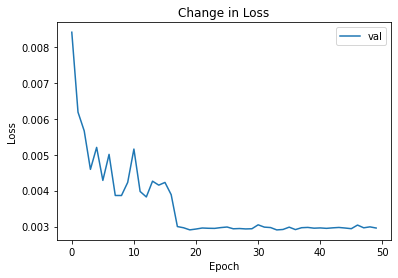

In [10]:
plt_data = {
    "val": test_losses
}
plot_graph(plt_data, "Loss")

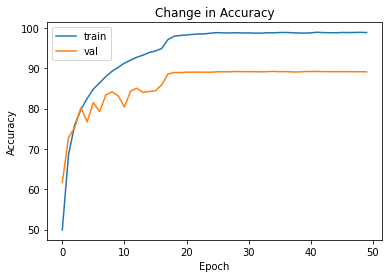

In [11]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [12]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

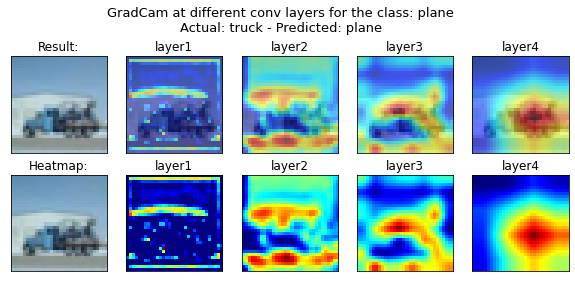

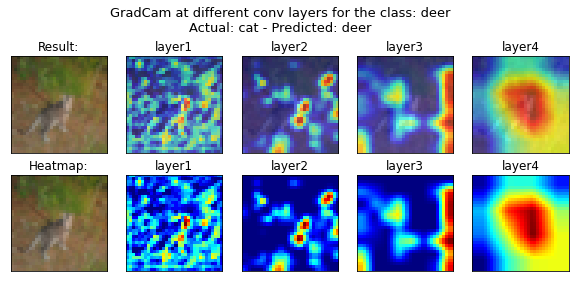

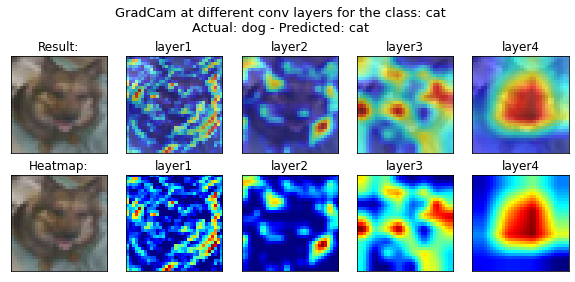

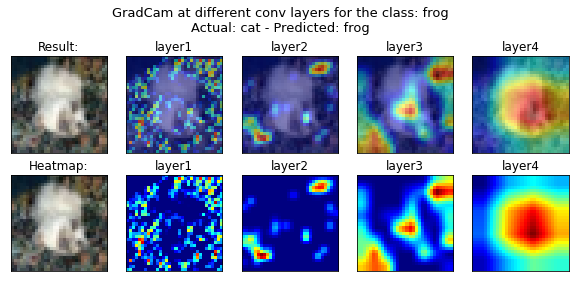

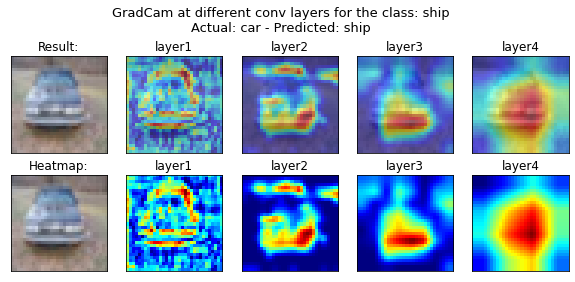

In [13]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

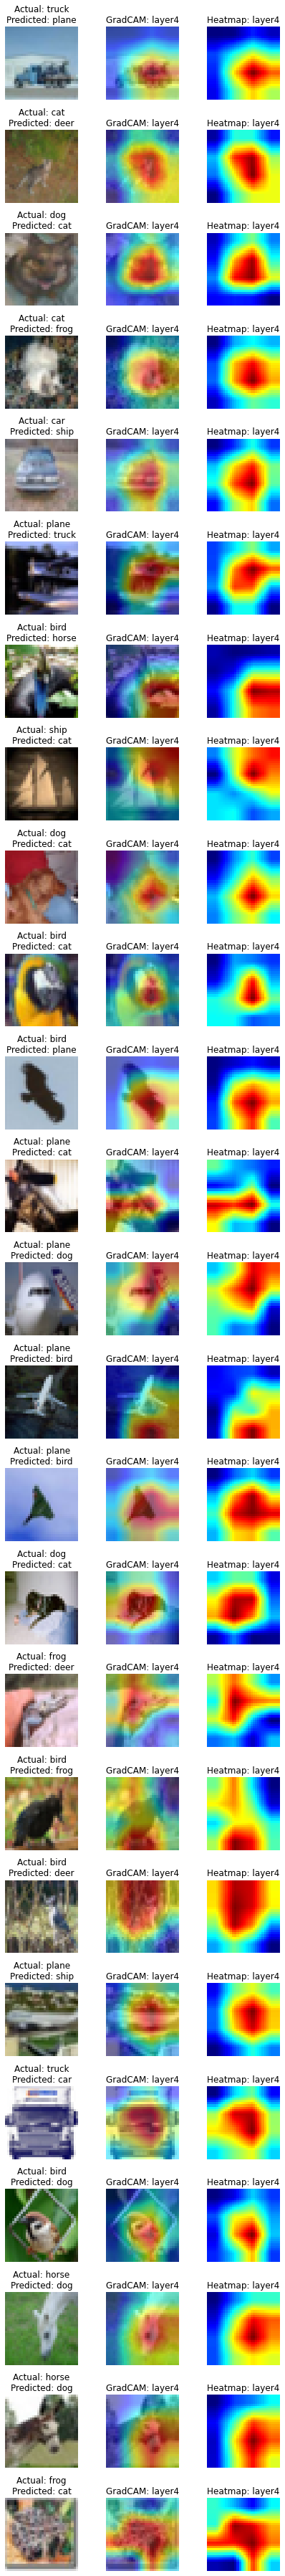

In [14]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)